<a href="https://colab.research.google.com/github/laaksonenl/machine-learning/blob/master/red_wine_quality_classification.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Red wine quality classification

In [20]:
! pip install -q kaggle
from google.colab import files

files.upload()

! mkdir ~/.kaggle
! cp kaggle.json ~/.kaggle/

! chmod 600 ~/.kaggle/kaggle.json

! kaggle datasets download -d 'uciml/red-wine-quality-cortez-et-al-2009'

Saving kaggle.json to kaggle (1).json
mkdir: cannot create directory ‘/root/.kaggle’: File exists
red-wine-quality-cortez-et-al-2009.zip: Skipping, found more recently modified local copy (use --force to force download)


In [21]:
%%bash
mkdir -p /content/data
unzip /content/red-wine-quality-cortez-et-al-2009.zip -d /content/data/

Archive:  /content/red-wine-quality-cortez-et-al-2009.zip


replace /content/data/winequality-red.csv? [y]es, [n]o, [A]ll, [N]one, [r]ename:  NULL
(EOF or read error, treating as "[N]one" ...)


In [22]:
import pandas as pd

data = pd.read_csv('/content/data/winequality-red.csv')

In [23]:
data.shape

(1599, 12)

In [24]:
from sklearn.model_selection import train_test_split

X = data.drop("quality", axis=1)
y = data["quality"]
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, shuffle=True, stratify=y)

## Data exploration

In [25]:
X_train.head()

,fixed acidity,volatile acidity,citric acid,residual sugar,chlorides,free sulfur dioxide,total sulfur dioxide,density,pH,sulphates,alcohol
447,9.3,0.48,0.29,2.1,0.127,6.0,16.0,0.99680,3.22,0.72,11.2
1496,7.7,0.54,0.26,1.9,0.089,23.0,147.0,0.99636,3.26,0.59,9.7
825,7.1,0.46,0.14,2.8,0.076,15.0,37.0,0.99624,3.36,0.49,10.7
139,7.8,0.56,0.19,2.0,0.081,17.0,108.0,0.99620,3.32,0.54,9.5
1247,7.4,0.55,0.19,1.8,0.082,15.0,34.0,0.99655,3.49,0.68,10.5


In [26]:
X_train.describe()

,fixed acidity,volatile acidity,citric acid,residual sugar,chlorides,free sulfur dioxide,total sulfur dioxide,density,pH,sulphates,alcohol
count,1279.000000,1279.000000,1279.000000,1279.000000,1279.000000,1279.000000,1279.000000,1279.000000,1279.000000,1279.000000,1279.000000
mean,8.334246,0.527201,0.275027,2.524277,0.088404,15.896403,46.349492,0.996745,3.308585,0.661486,10.431744
std,1.736184,0.179782,0.197060,1.338905,0.049889,10.338747,32.971158,0.001875,0.156366,0.175052,1.078186
min,4.600000,0.120000,0.000000,0.900000,0.012000,1.000000,6.000000,0.990070,2.740000,0.330000,8.400000
25%,7.100000,0.390000,0.100000,1.900000,0.070000,7.000000,22.000000,0.995600,3.205000,0.550000,9.500000
50%,7.900000,0.520000,0.260000,2.200000,0.079000,14.000000,37.000000,0.996770,3.310000,0.620000,10.200000
75%,9.300000,0.637500,0.440000,2.600000,0.091000,21.000000,62.000000,0.997800,3.400000,0.730000,11.100000
max,15.900000,1.580000,1.000000,15.500000,0.611000,68.000000,289.000000,1.003690,4.010000,2.000000,14.900000


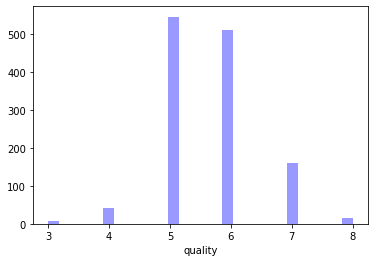

In [27]:
import seaborn as sns

sns.distplot(y_train, kde=False, color='blue')


In [28]:
y_train.value_counts()

5    545
6    510
7    159
4     42
8     15
3      8
Name: quality, dtype: int64

In [29]:
combined = pd.concat([X_train, y_train], axis=1)

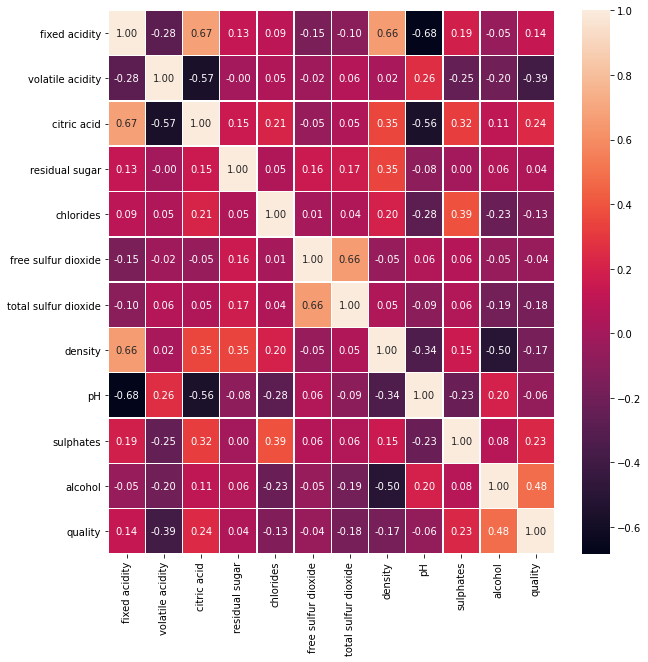

In [30]:
import matplotlib.pyplot as plt

figure, axes = plt.subplots(figsize = (10,10))

sns.heatmap(combined.corr(), annot = True, linewidths=.5, fmt = ".2f", ax=axes)
plt.show()

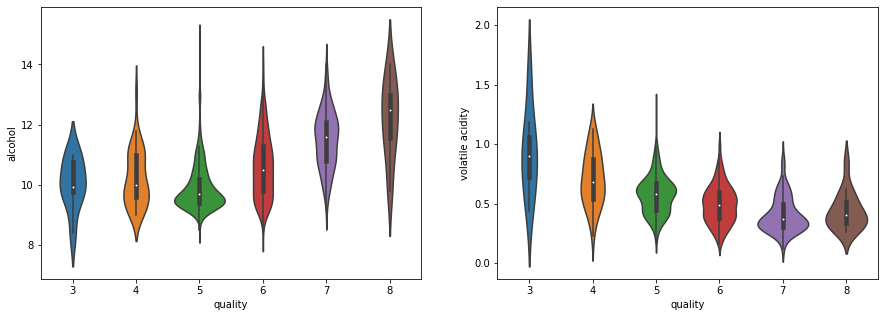

In [31]:
fig, axes = plt.subplots(1, 2, figsize =(15,5))

def violin(feature, ax):
  sns.violinplot(x='quality',
                 y=feature,
                 sizes=(10, 200),
                 data=combined,
                 ax=ax)

violin('alcohol', axes[0])
violin('volatile acidity', axes[1])

Since standard coefficient correlation captures only linear correlations, plot the pairs to detect nonlinear correlations.


In [32]:
combined['quality'].value_counts()

5    545
6    510
7    159
4     42
8     15
3      8
Name: quality, dtype: int64

In [33]:
x = combined.groupby(pd.cut(combined['quality'], bins=[1, 3, 7, 10]))
bin_keys = x.groups.keys()
labels = { 1: 'Bad', 2: 'Mediocre', 3: 'Good' }

tmp = combined.copy()
for i, b in enumerate(bin_keys, 1):
  idx = x.groups.get(b)
  tmp.loc[idx, 'quality'] = labels[i]

tmp.head()
tmp['quality'].value_counts()

Mediocre    1256
Good          15
Bad            8
Name: quality, dtype: int64

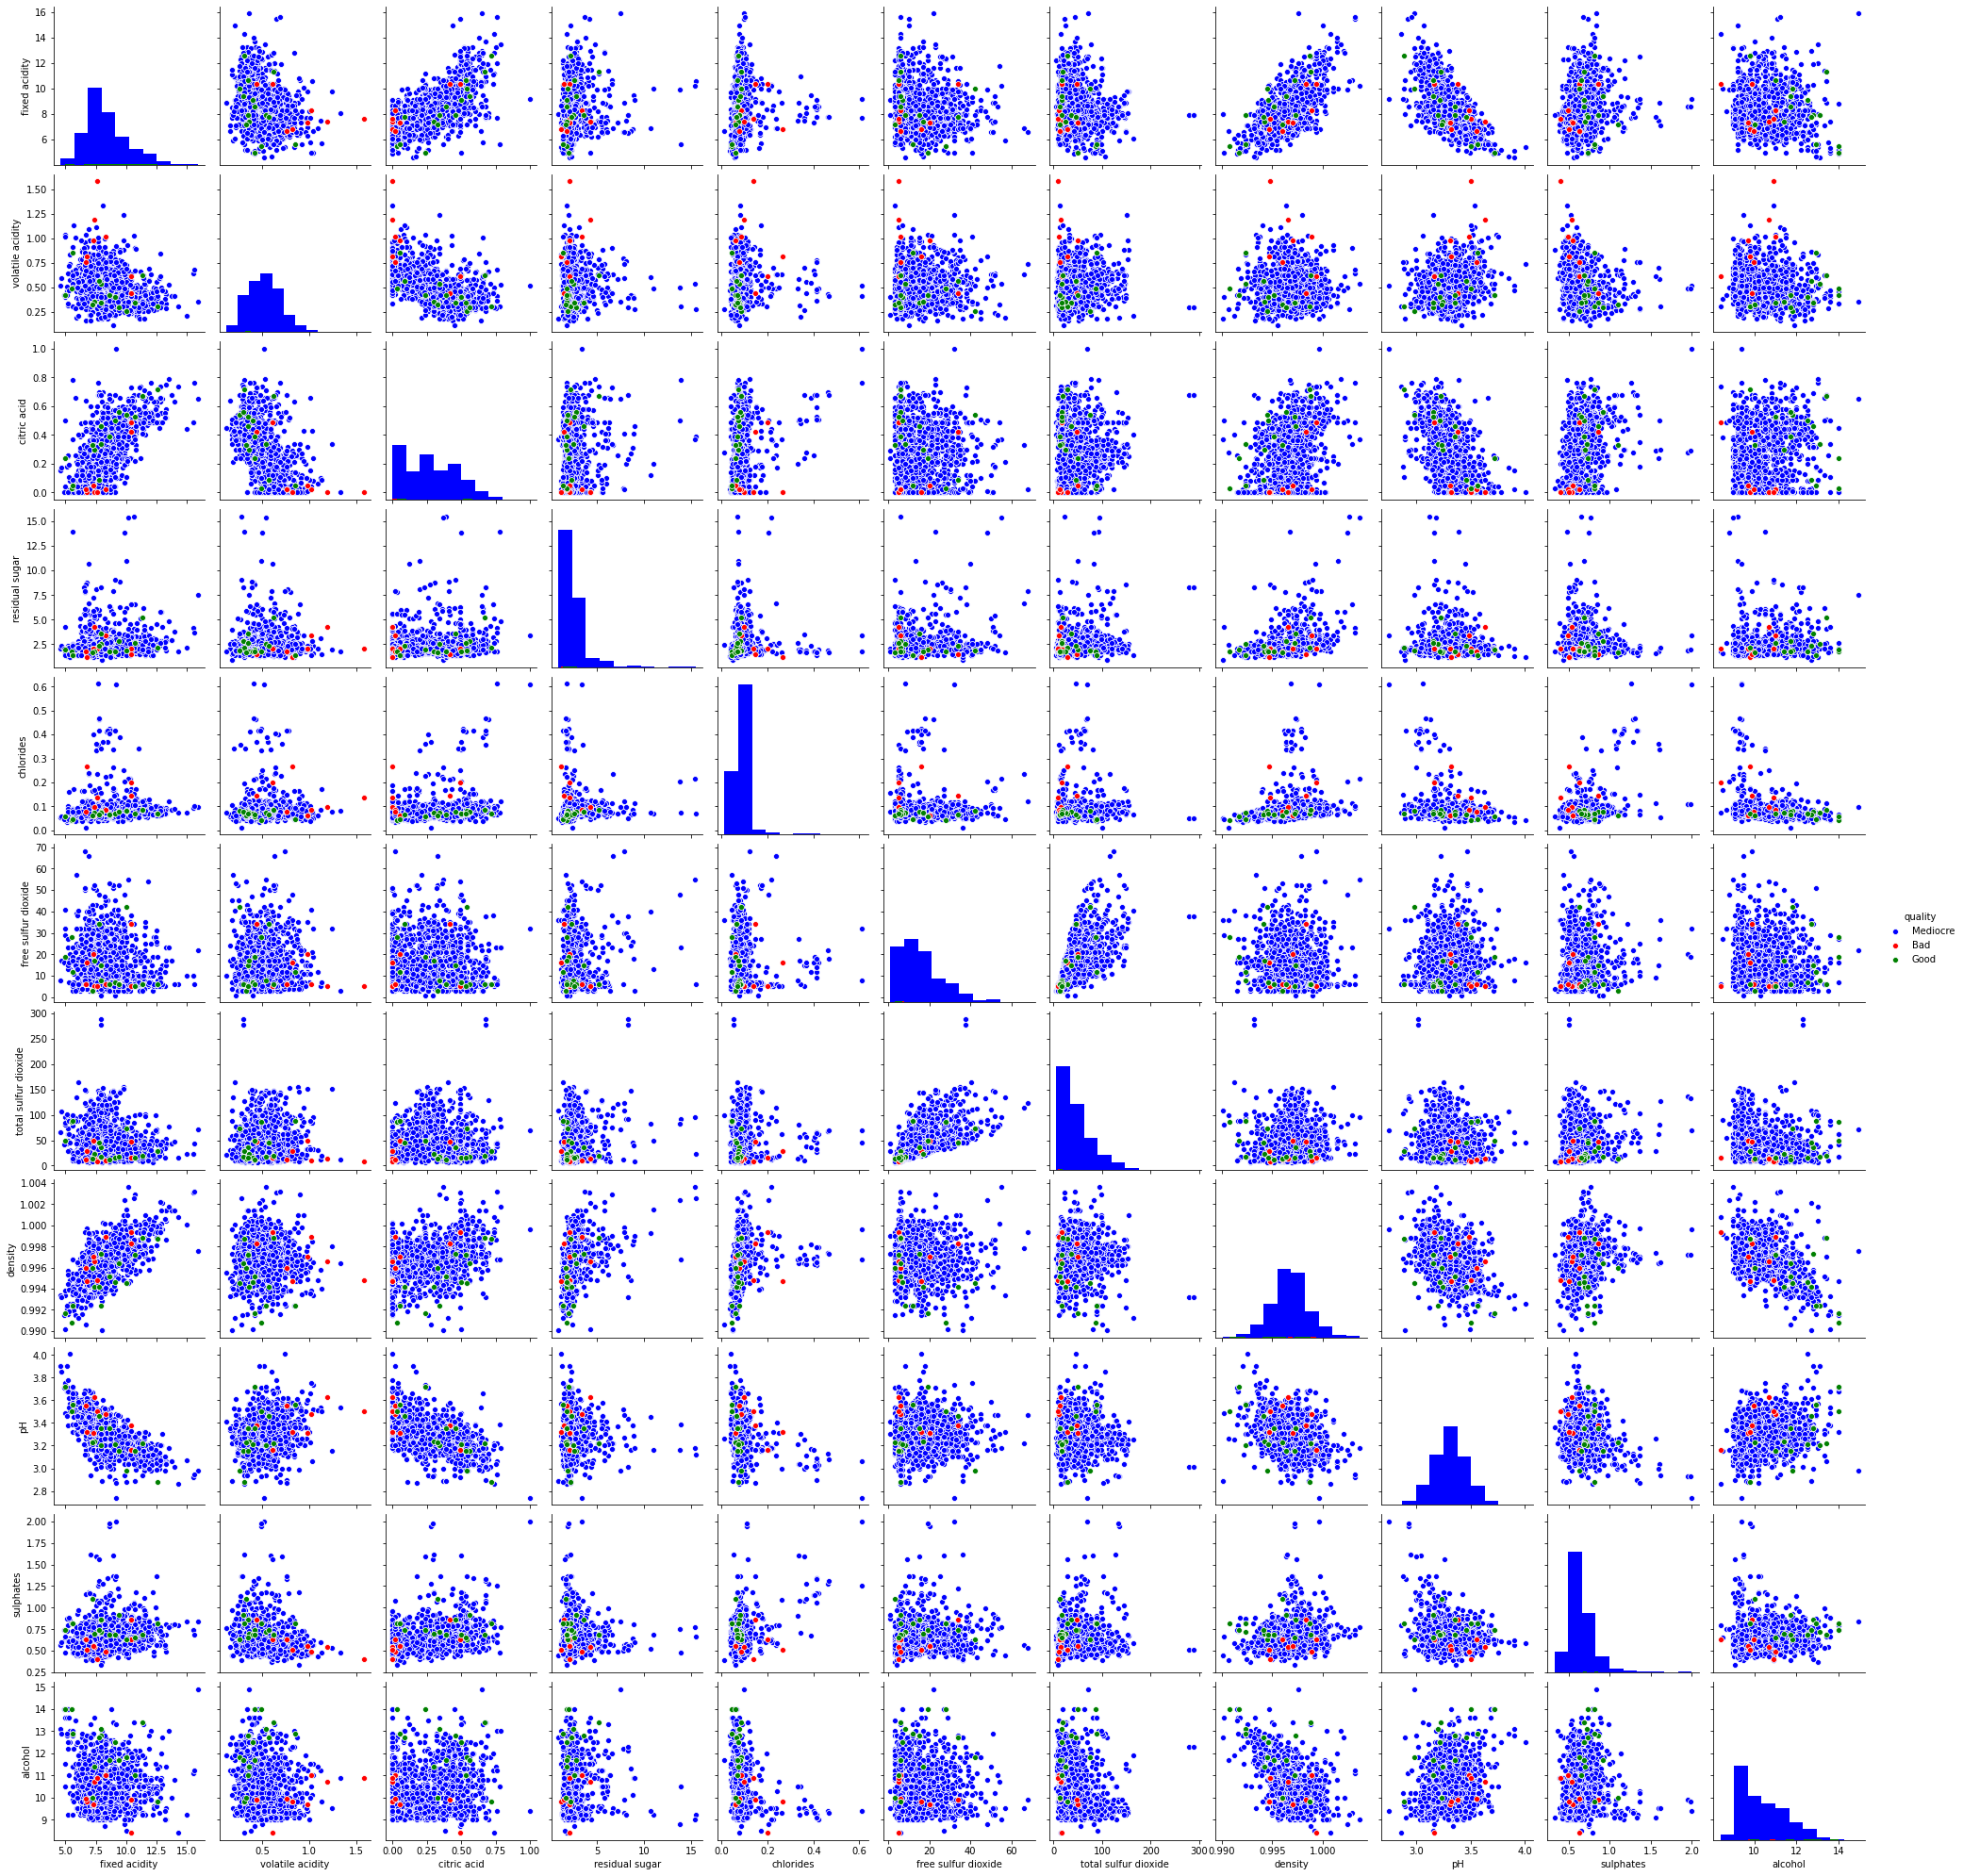

In [34]:
sns.pairplot(tmp, hue='quality', diag_kind='hist', palette={'Bad': 'red', 'Mediocre': 'blue', 'Good': 'green'})

## Models

#### Evaluation

In [51]:
from sklearn.model_selection import learning_curve
import numpy as np

def plot_learning_curve(estimator, title, X, y, ylim=None, cv=None):
    plt.figure()
    plt.title(title)
    if ylim is not None:
        plt.ylim(*ylim)

    plt.xlabel("Training examples")
    plt.ylabel("Score")

    train_sizes, train_scores, test_scores = learning_curve(estimator, X, y, cv=cv, 
                                                            train_sizes=np.linspace(.1, 1.0, 5))
    train_scores_mean = np.mean(train_scores, axis=1)
    train_scores_std = np.std(train_scores, axis=1)
    test_scores_mean = np.mean(test_scores, axis=1)
    test_scores_std = np.std(test_scores, axis=1)

    plt.grid()

    plt.fill_between(train_sizes, train_scores_mean - train_scores_std,
                     train_scores_mean + train_scores_std, alpha=0.1,
                     color="r")

    plt.plot(train_sizes, train_scores_mean, 'o-', color="r",
             label="Training score")

    plt.fill_between(train_sizes, test_scores_mean - test_scores_std,
                     test_scores_mean + test_scores_std, alpha=0.1, color="g")
                     
    plt.plot(train_sizes, test_scores_mean, 'o-', color="g",
             label="Cross-validation score")

    plt.legend(loc="best")
    
    return plt

In [52]:
from sklearn import metrics

def print_report(pipe, data, labels):
    y_pred = pipe.predict(data)
    report = metrics.classification_report(labels, y_pred, zero_division=0)
    print(report)
    print("Accuracy: {:0.3f}".format(metrics.accuracy_score(labels, y_pred)))
  

In [67]:
from sklearn.model_selection import StratifiedShuffleSplit

def evaluate(pipeline, name, data, labels):
  pipeline.fit(data, labels)
  sss = StratifiedShuffleSplit(n_splits=5, test_size=0.2, random_state=0)
  plot_learning_curve(pipeline, name, data, labels, ylim=(0.2, 1.0), cv=sss)
  print_report(pipeline, X_train, y_train)

### Logistic regression


In [54]:
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler, LabelEncoder
from sklearn.linear_model import LogisticRegression

logreg = Pipeline([
    ('Scaler', StandardScaler()),
    ('LogReg', LogisticRegression(max_iter=10000))
  ])

In [55]:
from sklearn.model_selection import GridSearchCV

def log_reg_gridsearch(pipe, X_train, y_train):
  log_reg_params = { 'LogReg__penalty': ['l1', 'l2'], 'LogReg__C': [0.001, 0.01, 0.1, 1, 10, 100, 1000]}
  grid_log_reg = GridSearchCV(pipe, log_reg_params)
  grid_log_reg.fit(X_train, y_train)

  log_reg = grid_log_reg.best_estimator_
  print("Best parameters: ", grid_log_reg.best_estimator_)
  print("Best Score for Logistic Regression: ", grid_log_reg.best_score_)
  return log_reg

In [56]:
import warnings
warnings.filterwarnings('ignore')

logreg = log_reg_gridsearch(logreg, X_train, y_train)

Best parameters:  Pipeline(memory=None,
         steps=[('Scaler',
                 StandardScaler(copy=True, with_mean=True, with_std=True)),
                ('LogReg',
                 LogisticRegression(C=10, class_weight=None, dual=False,
                                    fit_intercept=True, intercept_scaling=1,
                                    l1_ratio=None, max_iter=10000,
                                    multi_class='auto', n_jobs=None,
                                    penalty='l2', random_state=None,
                                    solver='lbfgs', tol=0.0001, verbose=0,
                                    warm_start=False))],
         verbose=False)
Best Score for Logistic Regression:  0.6028247549019607


              precision    recall  f1-score   support

           3       0.50      0.12      0.20         8
           4       0.67      0.05      0.09        42
           5       0.66      0.76      0.71       545
           6       0.55      0.61      0.58       510
           7       0.54      0.31      0.40       159
           8       0.00      0.00      0.00        15

    accuracy                           0.61      1279
   macro avg       0.49      0.31      0.33      1279
weighted avg       0.60      0.61      0.59      1279

Accuracy: 0.605


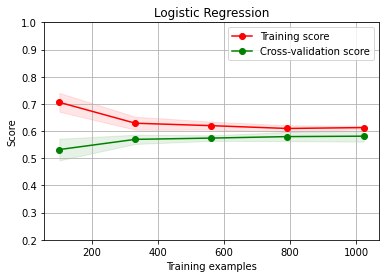

In [68]:
evaluate(logreg, 'Logistic Regression', X_train, y_train)

### RandomForestClassifier

In [75]:
from sklearn.ensemble import RandomForestClassifier

rfc = Pipeline([
    ('Scaler', StandardScaler()),
    ('RandomForest', RandomForestClassifier(n_estimators=10))
  ])

              precision    recall  f1-score   support

           3       1.00      1.00      1.00         8
           4       1.00      0.93      0.96        42
           5       0.97      1.00      0.98       545
           6       0.99      0.98      0.99       510
           7       0.99      0.97      0.98       159
           8       1.00      0.93      0.97        15

    accuracy                           0.98      1279
   macro avg       0.99      0.97      0.98      1279
weighted avg       0.98      0.98      0.98      1279

Accuracy: 0.984


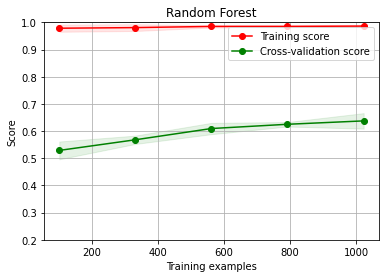

In [76]:
evaluate(rfc, 'Random Forest', X_train, y_train)